# Dynamic Averaging Results: Simple NN

# Imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc

from dyn_fed.utils.report_utils import generate_all_pivots, generate_packet_size_pivots
from dyn_fed.viz.report import plot_results, plot_pkt_size, plot_model_performance

rc('text', usetex=True)

In [3]:
project_dir = Path().resolve().parents[1]
project_dir

PosixPath('/Users/sashlinreddy/repos/masters/dyn-fed')

In [4]:
masters_dir = Path().resolve().parents[2]
masters_dir

PosixPath('/Users/sashlinreddy/repos/masters')

In [5]:
thesis_dir = (masters_dir/"fed-learn-thesis").resolve()
thesis_dir

PosixPath('/Users/sashlinreddy/repos/masters/fed-learn-thesis')

Join results

In [6]:
df1 = pd.read_csv(project_dir/"data/20200427-results.csv")
df2 = pd.read_csv(project_dir/"data/20200428-results.csv")
df3 = pd.read_csv(project_dir/"data/20200509-results.csv")
df4 = pd.read_csv(project_dir/"data/20200510-results.csv")
results = pd.concat([df1, df2, df3]).reset_index(drop=True)

In [7]:
updt_idx = results.query(
    'model_type == "nn1" and optimizer == "sgd" and n_clients == 8'
    'and comm_mode == 2 and noniid == 1 and unbalanced == 0 and dataset =="mnist"'
).index

In [8]:
results.loc[updt_idx]

,jobid,dataset,model_type,optimizer,n_clients,agg_mode,interval,comm_mode,noniid,unbalanced,...,epochs,delta_threshold,error,time,train_acc,test_acc,train_loss,test_loss,pkt_size,comm_rounds
966,61542,mnist,nn1,sgd,8,1,1,2,1,0,...,50,NaN,0,69.592954,30.165,29.67,2.0467,2.221,31.839,82.0


In [9]:
results.loc[updt_idx] = df4.query('dataset == "mnist" and model_type == "nn1"').values

# Performance analysis

In [10]:
metrics = ['time', 'test_loss', 'test_acc', 'gen_gap', 'pkt_size', 'avg_comm_rate']

In [11]:
model = 'NN'

## MNIST - SGD

In [12]:
dataset = 'MNIST'
optimizer = 'SGD'

In [13]:
results = results.query('n_clients < 64')

In [14]:
results.shape

(2088, 21)

In [15]:
results.head()

,jobid,dataset,model_type,optimizer,n_clients,agg_mode,interval,comm_mode,noniid,unbalanced,...,epochs,delta_threshold,error,time,train_acc,test_acc,train_loss,test_loss,pkt_size,comm_rounds
0,60576.0,fashion-mnist,logistic,adam,32,1,1,0,0,1,...,100,NaN,0,130.226681,82.9133,82.11,1.5907,1.5992,92.919,3100.0
1,60577.0,mnist,logistic,sgd,24,1,20,0,0,0,...,100,NaN,0,20.272419,83.5967,84.42,1.7588,1.7534,3.447,115.0
2,60578.0,mnist,logistic,sgd,8,1,20,0,1,1,...,100,NaN,0,41.749354,67.8100,68.67,1.5134,1.8902,1.049,35.0
3,60579.0,fashion-mnist,cnn1,adam,24,1,1,1,1,1,...,50,NaN,0,342.623015,75.6150,74.52,1.5820,1.7204,1831.963,692.0
4,60580.0,fashion-mnist,cnn1,adam,24,1,1,2,1,0,...,50,NaN,1,NaN,12.1133,12.21,2.3042,2.3043,NaN,NaN


In [16]:
results.loc[:, "avg_comm_rate"] = results["comm_rounds"] / (results["n_clients"] - 1)

In [17]:
results.loc[:, "gen_gap"] = (results["test_loss"] - results["train_loss"]) / ((results["test_loss"] + results["train_loss"]))

In [18]:
results.loc[:, "delta_threshold"] = results.delta_threshold.fillna(0.0)

In [19]:
error_query = 'error == 1'
results = results.drop(results.query(error_query).index).reset_index(drop=True)

In [20]:
results.loc[:, "n_clients"] = results["n_clients"] - 1

In [21]:
drop_query = "(delta_threshold <= 0.0 or delta_threshold > 2.0) and comm_mode == 3"
adam_results = results.copy()
results = results.drop(results.query(drop_query).index).reset_index(drop=True)

In [22]:
nn_mnist = results.query(
    "dataset == 'mnist' and model_type=='nn1' and n_clients < 63"
    " and optimizer == 'sgd'"
)
nn_fmnist = results.query(
    "dataset == 'fashion-mnist' and model_type=='nn1' and n_clients < 63"
    " and optimizer == 'sgd'"
)

In [23]:
mnist_res, mnist_q = generate_all_pivots(nn_mnist, metrics=metrics)

### Wall time

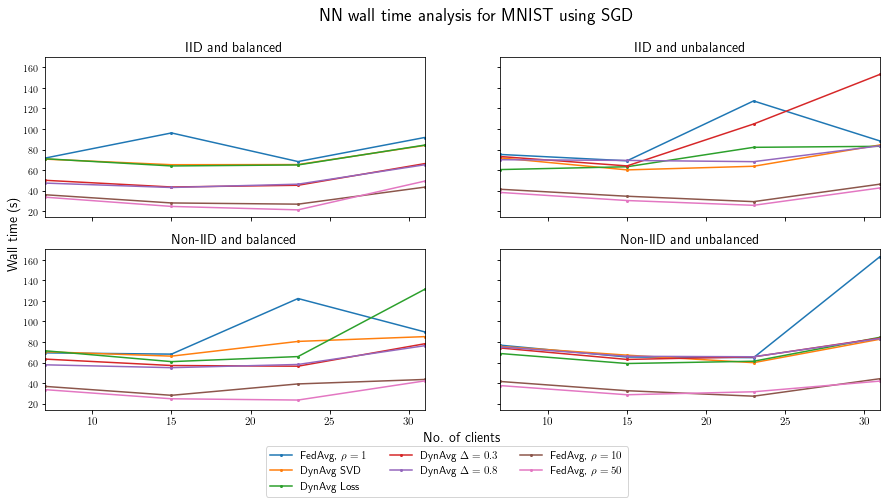

In [24]:
titles = ['IID and balanced', 'IID and unbalanced', 'Non-IID and balanced', 'Non-IID and unbalanced']
plot_results(
    mnist_res,
    'time',
    xlabel='No. of clients',
    ylabel='Wall time (s)',
    suptitle=f'{model} wall time analysis for MNIST using SGD',
    titles=titles
)
# plt.savefig('../reports/figures/time-analysis.png', dpi=500, format='png')
plt.savefig(thesis_dir/'figures/nn-mnist-sgd-time.png', dpi=500, format='png', bbox_inches='tight')

### Accuracy

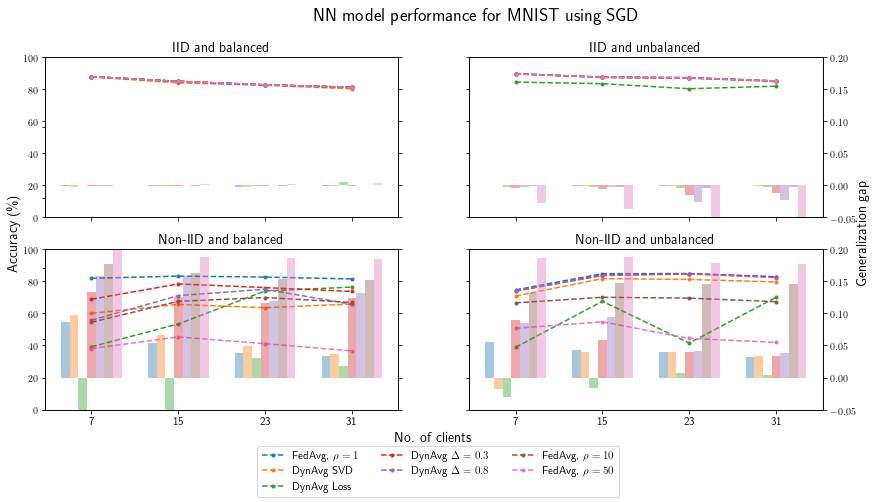

In [25]:
plot_model_performance(
    mnist_res,
    titles=titles,
    xlabel='No. of clients',
    ylabel1='Accuracy (\%)',
    ylabel2='Generalization gap',
    suptitle=f'{model} model performance for {dataset} using {optimizer}'
)
plt.savefig(
    thesis_dir/f'figures/{model.lower()}-mnist-{optimizer.lower()}-mp.png',
    dpi=500,
    format='png',
    bbox_inches='tight'
)

In [26]:
# plot_results(
#     mnist_res,
#     'test_acc',
#     xlabel='No. of clients',
#     ylabel='Accuracy (\%)',
#     suptitle=f'{model} accuracy analysis for MNIST using SGD',
#     titles=titles
# )
# # plt.savefig('../reports/figures/time-analysis.png', dpi=500, format='png')
# plt.savefig(thesis_dir/'figures/nn-mnist-sgd-acc.png', dpi=500, format='png')

### Generalization gap

In [27]:
# plot_results(
#     mnist_res,
#     'gen_gap',
#     xlabel='No. of clients',
#     ylabel='Generalization gap',
#     suptitle=f'{model} generalization gap analysis for MNIST using SGD',
#     titles=titles,
#     kind='bar'
# )
# # plt.savefig('../reports/figures/time-analysis.png', dpi=500, format='png')
# plt.savefig(thesis_dir/'figures/nn-mnist-sgd-gen-gap.png', dpi=500, format='png')

### Packet size

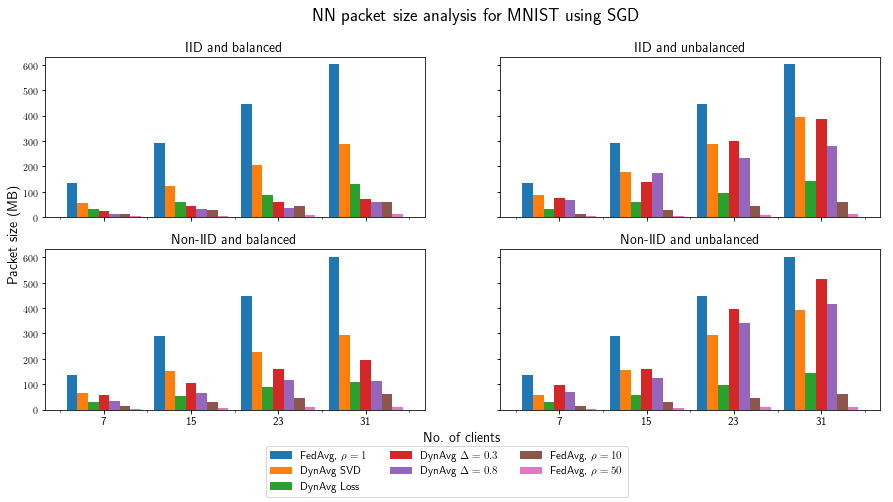

In [28]:
plot_results(
    mnist_res,
    'pkt_size',
    xlabel='No. of clients',
    ylabel='Packet size (MB)',
    suptitle=f'{model} packet size analysis for MNIST using SGD',
    titles=titles,
    kind='bar'
)
plt.savefig(thesis_dir/'figures/nn-mnist-sgd-pkt.png', dpi=500, format='png', bbox_inches='tight')

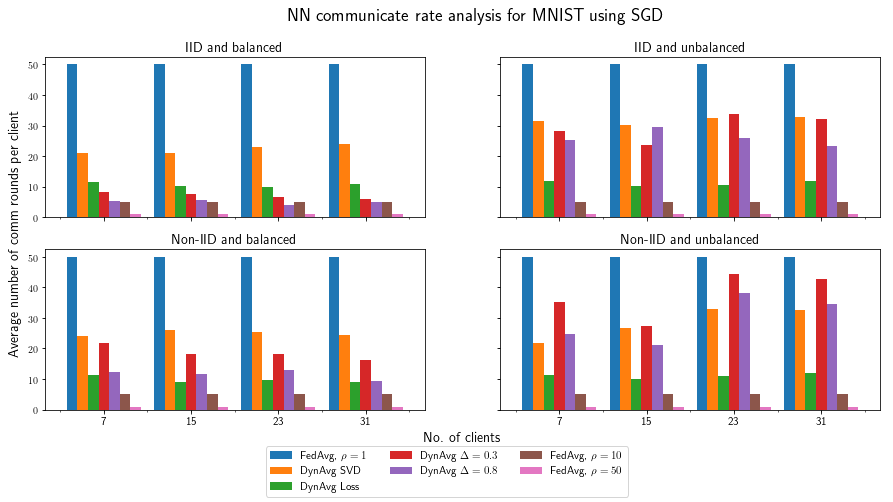

In [29]:
plot_results(
    mnist_res,
    'avg_comm_rate',
    xlabel='No. of clients',
    ylabel='Average number of comm rounds per client',
    suptitle=f'{model} communicate rate analysis for MNIST using SGD',
    titles=titles,
    kind='bar'
)
plt.savefig(thesis_dir/'figures/nn-mnist-sgd-cr.png', dpi=500, format='png', bbox_inches='tight')

## Fashion-MNIST - SGD

In [30]:
dataset = 'Fashion-MNIST'
optimizer = 'SGD'

In [31]:
fmnist_res, fmnist_q = generate_all_pivots(nn_fmnist, metrics=metrics)

### Wall time

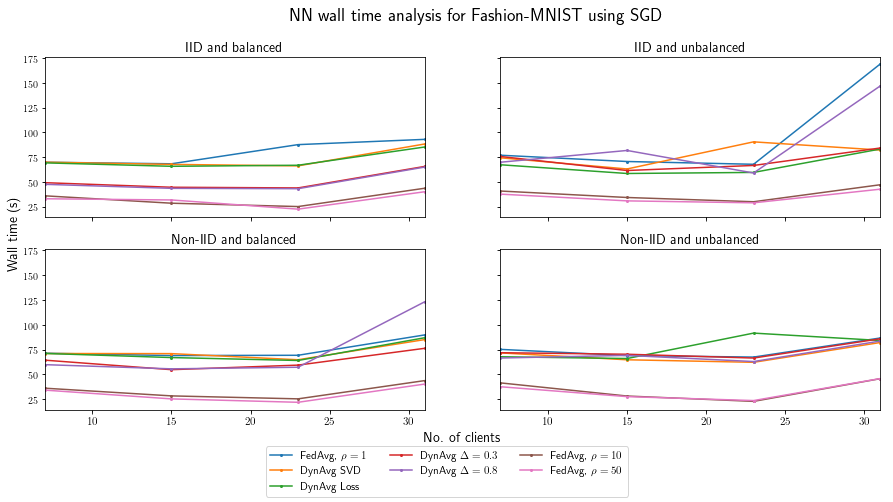

In [32]:
titles = ['IID and balanced', 'IID and unbalanced', 'Non-IID and balanced', 'Non-IID and unbalanced']
plot_results(
    fmnist_res,
    'time',
    xlabel='No. of clients',
    ylabel='Wall time (s)',
    suptitle=f'{model} wall time analysis for Fashion-MNIST using SGD',
    titles=titles
)
# plt.savefig('../reports/figures/time-analysis.png', dpi=500, format='png')
plt.savefig(thesis_dir/'figures/nn-fmnist-sgd-time.png', dpi=500, format='png', bbox_inches='tight')

### Accuracy

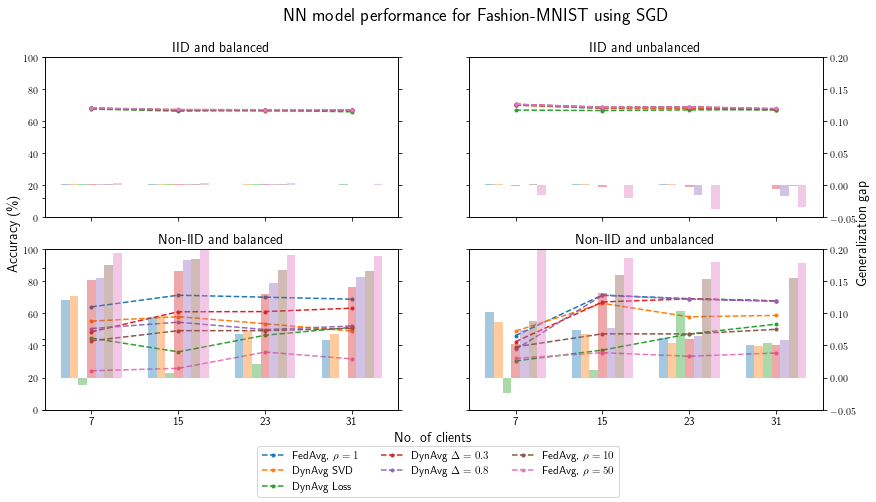

In [33]:
plot_model_performance(
    fmnist_res,
    titles=titles,
    xlabel='No. of clients',
    ylabel1='Accuracy (\%)',
    ylabel2='Generalization gap',
    suptitle=f'{model} model performance for {dataset} using {optimizer}',
    ylim2=(-0.05, 0.20)
)
plt.savefig(
    thesis_dir/f'figures/{model.lower()}-fmnist-{optimizer.lower()}-mp.png',
    dpi=500,
    format='png',
    bbox_inches='tight'
)

In [34]:
# plot_results(
#     fmnist_res,
#     'test_acc',
#     xlabel='No. of clients',
#     ylabel='Accuracy (\%)',
#     suptitle=f'{model} accuracy analysis for Fashion-MNIST using SGD',
#     titles=titles
# )
# # plt.savefig('../reports/figures/time-analysis.png', dpi=500, format='png')
# plt.savefig(thesis_dir/'figures/nn-fmnist-sgd-acc.png', dpi=500, format='png')

### Generalization gap

In [35]:
# plot_results(
#     fmnist_res,
#     'gen_gap',
#     xlabel='No. of clients',
#     ylabel='Generalization gap',
#     suptitle=f'{model} generalization gap analysis for Fashion-MNIST using SGD',
#     titles=titles,
#     kind='bar'
# )
# # plt.savefig('../reports/figures/time-analysis.png', dpi=500, format='png')
# plt.savefig(thesis_dir/'figures/nn-fmnist-sgd-gen-gap.png', dpi=500, format='png')

### Packet size

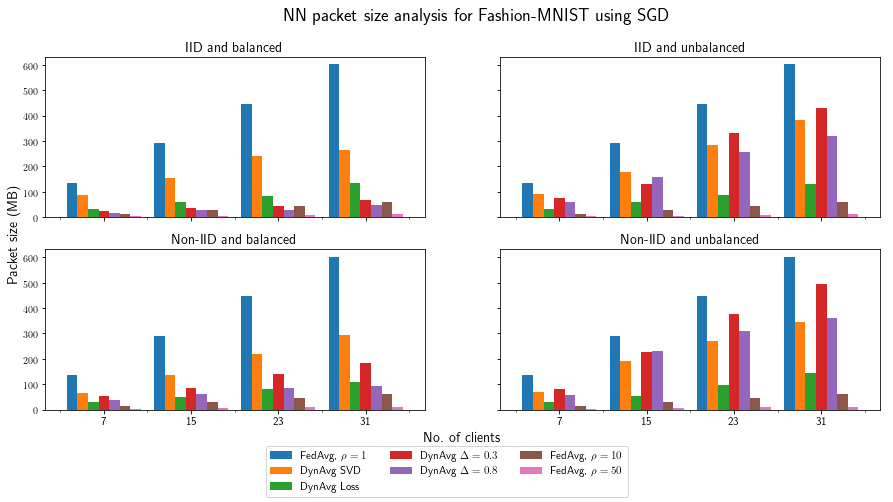

In [36]:
plot_results(
    fmnist_res,
    'pkt_size',
    xlabel='No. of clients',
    ylabel='Packet size (MB)',
    suptitle=f'{model} packet size analysis for Fashion-MNIST using SGD',
    titles=titles,
    kind='bar'
)
plt.savefig(thesis_dir/'figures/nn-fmnist-sgd-pkt.png', dpi=500, format='png', bbox_inches='tight')

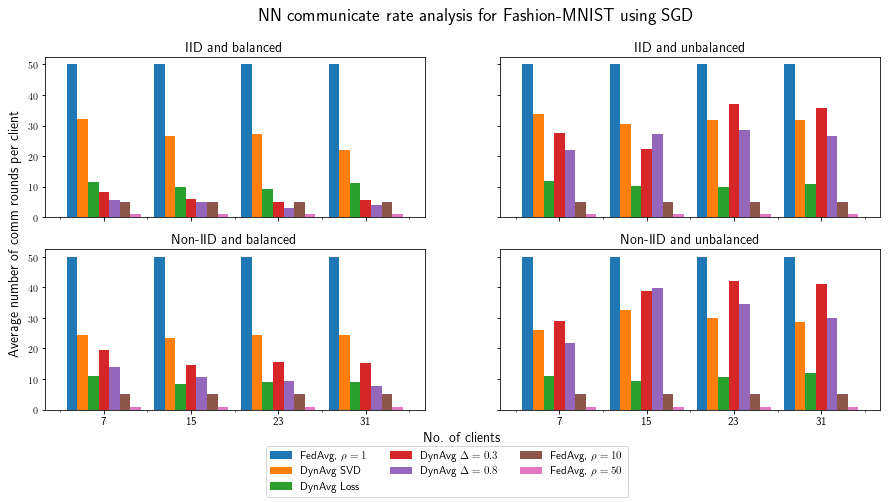

In [37]:
plot_results(
    fmnist_res,
    'avg_comm_rate',
    xlabel='No. of clients',
    ylabel='Average number of comm rounds per client',
    suptitle=f'{model} communicate rate analysis for Fashion-MNIST using SGD',
    titles=titles,
    kind='bar'
)
plt.savefig(thesis_dir/'figures/nn-fmnist-sgd-cr.png', dpi=500, format='png', bbox_inches='tight')

## MNIST - Adam

In [38]:
dataset = 'MNIST'
optimizer = 'Adam'

In [39]:
drop_query = '(delta_threshold == 0.0 or delta_threshold < 4.0) and comm_mode == 3'
adam_results = adam_results.drop(adam_results.query(drop_query).index).reset_index(drop=True)

In [40]:
nn_mnist = adam_results.query(
    "dataset == 'mnist' and model_type=='nn1' and n_clients < 63"
    " and optimizer == 'adam'"
)
nn_fmnist = adam_results.query(
    "dataset == 'fashion-mnist' and model_type=='nn1' and n_clients < 63"
    " and optimizer == 'adam'"
)

In [41]:
mnist_res, mnist_q = generate_all_pivots(nn_mnist, metrics=metrics)

### Wall time

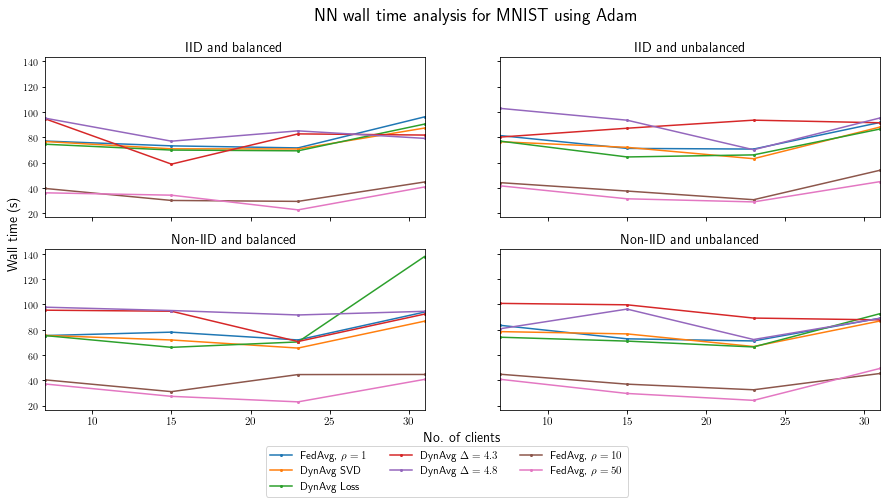

In [42]:
titles = ['IID and balanced', 'IID and unbalanced', 'Non-IID and balanced', 'Non-IID and unbalanced']
plot_results(
    mnist_res,
    'time',
    xlabel='No. of clients',
    ylabel='Wall time (s)',
    suptitle=f'{model} wall time analysis for MNIST using Adam',
    titles=titles
)
# plt.savefig('../reports/figures/time-analysis.png', dpi=500, format='png')
plt.savefig(thesis_dir/'figures/nn-mnist-adam-time.png', dpi=500, format='png', bbox_inches='tight')

### Accuracy

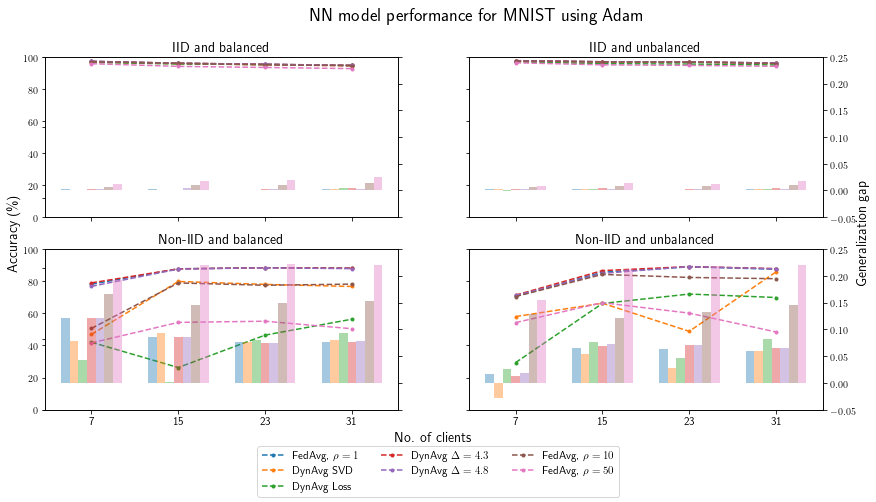

In [43]:
plot_model_performance(
    mnist_res,
    titles=titles,
    xlabel='No. of clients',
    ylabel1='Accuracy (\%)',
    ylabel2='Generalization gap',
    suptitle=f'{model} model performance for {dataset} using {optimizer}',
    ylim2=(-0.05, 0.25)
)
plt.savefig(
    thesis_dir/f'figures/{model.lower()}-mnist-{optimizer.lower()}-mp.png',
    dpi=500,
    format='png',
    bbox_inches='tight'
)

In [44]:
# plot_results(
#     mnist_res,
#     'test_acc',
#     xlabel='No. of clients',
#     ylabel='Accuracy (\%)',
#     suptitle=f'{model} accuracy analysis for MNIST using Adam',
#     titles=titles
# )
# # plt.savefig('../reports/figures/time-analysis.png', dpi=500, format='png')
# plt.savefig(thesis_dir/'figures/nn-mnist-adam-acc.png', dpi=500, format='png')

### Generalization gap

In [45]:
# plot_results(
#     mnist_res,
#     'gen_gap',
#     xlabel='No. of clients',
#     ylabel='Generalization gap',
#     suptitle=f'{model} generalization gap analysis for MNIST using Adam',
#     titles=titles,
#     kind='bar'
# )
# # plt.savefig('../reports/figures/time-analysis.png', dpi=500, format='png')
# plt.savefig(thesis_dir/'figures/nn-mnist-adam-gen-gap.png', dpi=500, format='png')

### Packet size

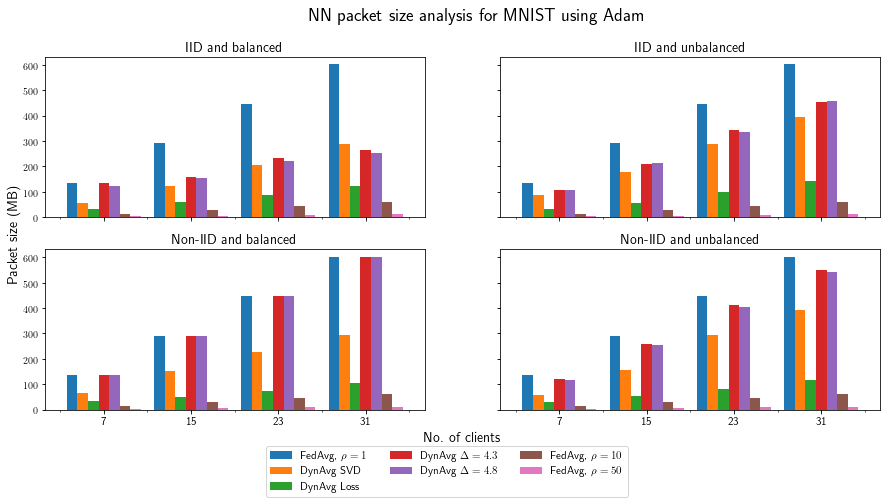

In [46]:
plot_results(
    mnist_res,
    'pkt_size',
    xlabel='No. of clients',
    ylabel='Packet size (MB)',
    suptitle=f'{model} packet size analysis for MNIST using Adam',
    titles=titles,
    kind='bar'
)
plt.savefig(thesis_dir/'figures/nn-mnist-adam-pkt.png', dpi=500, format='png', bbox_inches='tight')

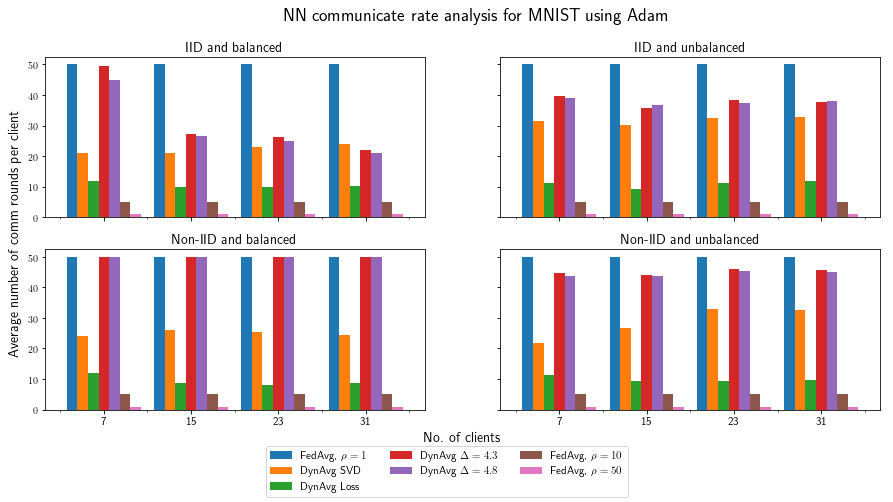

In [47]:
plot_results(
    mnist_res,
    'avg_comm_rate',
    xlabel='No. of clients',
    ylabel='Average number of comm rounds per client',
    suptitle=f'{model} communicate rate analysis for MNIST using Adam',
    titles=titles,
    kind='bar'
)
plt.savefig(thesis_dir/'figures/nn-mnist-adam-cr.png', dpi=500, format='png', bbox_inches='tight')

## Fashion-MNIST - Adam

In [48]:
dataset = 'Fashion-MNIST'
optimizer = 'Adam'

In [49]:
fmnist_res, fmnist_q = generate_all_pivots(nn_fmnist, metrics=metrics)

### Wall time

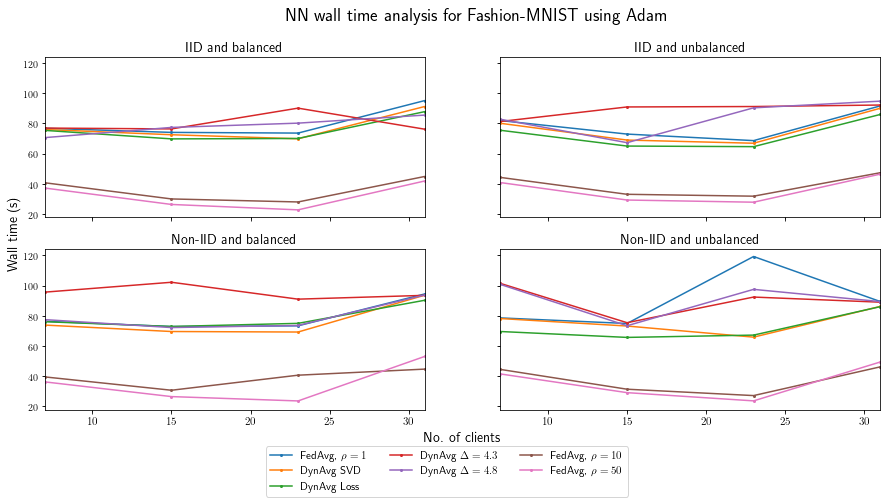

In [50]:
titles = ['IID and balanced', 'IID and unbalanced', 'Non-IID and balanced', 'Non-IID and unbalanced']
plot_results(
    fmnist_res,
    'time',
    xlabel='No. of clients',
    ylabel='Wall time (s)',
    suptitle=f'{model} wall time analysis for Fashion-MNIST using Adam',
    titles=titles
)
# plt.savefig('../reports/figures/time-analysis.png', dpi=500, format='png')
plt.savefig(thesis_dir/'figures/nn-fmnist-adam-time.png', dpi=500, format='png', bbox_inches='tight')

### Accuracy

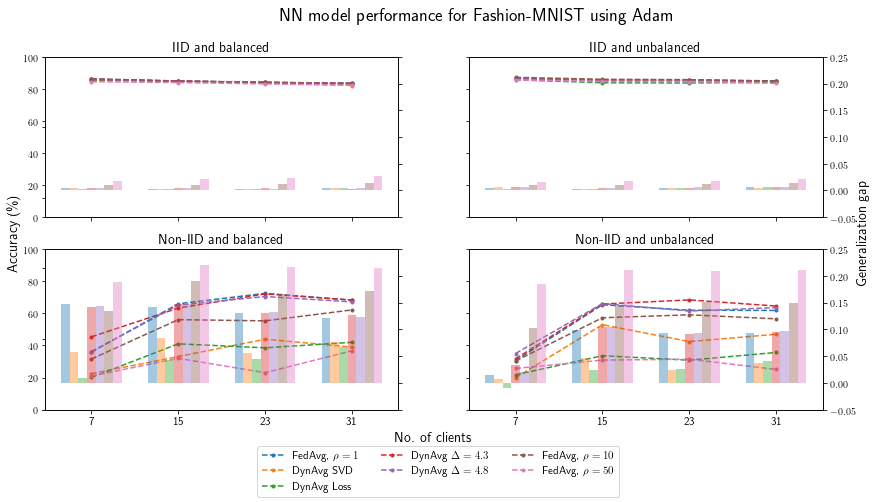

In [51]:
plot_model_performance(
    fmnist_res,
    titles=titles,
    xlabel='No. of clients',
    ylabel1='Accuracy (\%)',
    ylabel2='Generalization gap',
    suptitle=f'{model} model performance for {dataset} using {optimizer}',
    ylim2=(-0.05, 0.25)
)
plt.savefig(
    thesis_dir/f'figures/{model.lower()}-fmnist-{optimizer.lower()}-mp.png',
    dpi=500,
    format='png',
    bbox_inches='tight'
)

In [52]:
# plot_results(
#     fmnist_res,
#     'test_acc',
#     xlabel='No. of clients',
#     ylabel='Accuracy (\%)',
#     suptitle=f'{model} accuracy analysis for Fashion-MNIST using Adam',
#     titles=titles
# )
# # plt.savefig('../reports/figures/time-analysis.png', dpi=500, format='png')
# plt.savefig(thesis_dir/'figures/nn-fmnist-adam-acc.png', dpi=500, format='png')

### Generalization gap

In [53]:
# plot_results(
#     fmnist_res,
#     'gen_gap',
#     xlabel='No. of clients',
#     ylabel='Generalization gap',
#     suptitle=f'{model} generalization gap analysis for Fashion-MNIST using Adam',
#     titles=titles,
#     kind='bar'
# )
# # plt.savefig('../reports/figures/time-analysis.png', dpi=500, format='png')
# plt.savefig(thesis_dir/'figures/nn-fmnist-adam-gen-gap.png', dpi=500, format='png')

### Packet size

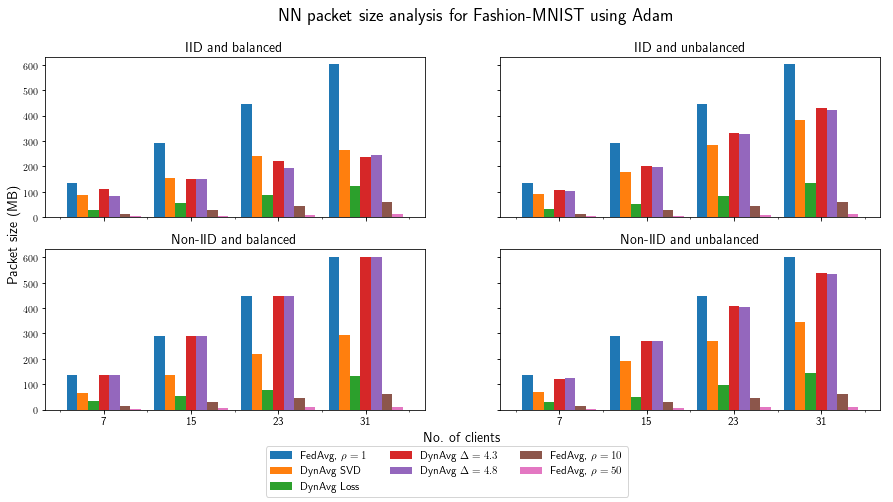

In [54]:
plot_results(
    fmnist_res,
    'pkt_size',
    xlabel='No. of clients',
    ylabel='Packet size (MB)',
    suptitle=f'{model} packet size analysis for Fashion-MNIST using Adam',
    titles=titles,
    kind='bar'
)
plt.savefig(thesis_dir/'figures/nn-fmnist-adam-pkt.png', dpi=500, format='png', bbox_inches='tight')

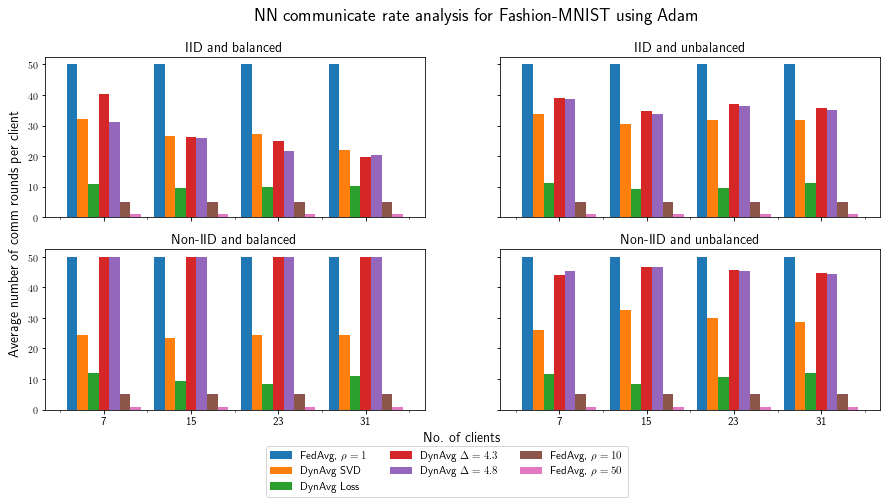

In [55]:
plot_results(
    fmnist_res,
    'avg_comm_rate',
    xlabel='No. of clients',
    ylabel='Average number of comm rounds per client',
    suptitle=f'{model} communicate rate analysis for Fashion-MNIST using Adam',
    titles=titles,
    kind='bar'
)
plt.savefig(thesis_dir/'figures/nn-fmnist-adam-cr.png', dpi=500, format='png', bbox_inches='tight')